# 1. Settings

## 1.1 User variables

In [1]:
MAX_DAY = 4
NB_RUNS = 30

TARGETS = ["O15"]
HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
THREADS = 8
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

display(df)

for target in TARGETS:
    for val in df[target].unique():
        print(val,len(df[df[target] == val]))

Training dataset:


,O15,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore_monolete_,Spore_trilete,Aquatics
0,1,1,1,2,2,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,1,1,1,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,2,2,0
2,1,1,2,2,2,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,1,2,2,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,1,2,0,2,2,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
5,1,2,0,1,1,1,0,0,1,0,...,1,1,1,1,0,1,0,0,0,0
6,0,0,1,2,2,1,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
7,1,1,0,2,1,1,0,0,0,0,...,2,0,0,0,0,1,1,1,0,2
8,2,1,0,1,1,1,0,0,1,0,...,0,0,1,0,1,0,2,2,0,2
9,1,2,0,2,2,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1


1 23
0 11
2 1


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "body", "rule_size"])

for run_id in range(NB_RUNS):
    # Shuffle variables
    random.shuffle(col_order)
    df = df[col_order]

    FEATURES = [c for c in df.columns if c not in TARGETS]

    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="pride") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})

    # Save rules
    rules_data = []

    for r in model.rules:
        body = ""
        for i in sorted(list(r.body.items())):
            body += i[1].to_string() + ", "
        if (len(body)>0):
            body = body[:-2]
        rules_data.append([r.head.variable, r.head.value, body, r.size(),r]) #, r.to_string()])

    df_rules = pd.DataFrame(rules_data, columns=["head_variable", "head_value", "body", "rule_size","raw_rule"]) #, "rule_raw_form"])

    nb_rules_of_run = len(df_rules)
    nb_rules_total_before = len(df_output)

    df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
    df_output.drop_duplicates(subset=["head_variable", "head_value", "body", "rule_size"], inplace=True)

    nb_new_rules = len(df_output) - nb_rules_total_before
    nb_duplicate_rules = nb_rules_of_run - nb_new_rules
    
    print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)


Run 1/30 - new rules found: 97 - total: 97 - duplicate: 0
Run 2/30 - new rules found: 107 - total: 204 - duplicate: 43
Run 3/30 - new rules found: 67 - total: 271 - duplicate: 76
Run 4/30 - new rules found: 70 - total: 341 - duplicate: 86
Run 5/30 - new rules found: 35 - total: 376 - duplicate: 89
Run 6/30 - new rules found: 40 - total: 416 - duplicate: 103
Run 7/30 - new rules found: 71 - total: 487 - duplicate: 64
Run 8/30 - new rules found: 39 - total: 526 - duplicate: 92
Run 9/30 - new rules found: 32 - total: 558 - duplicate: 53
Run 10/30 - new rules found: 42 - total: 600 - duplicate: 83
Run 11/30 - new rules found: 18 - total: 618 - duplicate: 120
Run 12/30 - new rules found: 44 - total: 662 - duplicate: 118
Run 13/30 - new rules found: 14 - total: 676 - duplicate: 100
Run 14/30 - new rules found: 33 - total: 709 - duplicate: 86
Run 15/30 - new rules found: 17 - total: 726 - duplicate: 102
Run 16/30 - new rules found: 21 - total: 747 - duplicate: 108
Run 17/30 - new rules found:

,head_variable,head_value,body,rule_size,raw_rule
0,O15,0,Tilia(1),1,O15(0) :- Tilia(1).
1,O15,0,"Juniperus(2), Picea(0)",2,"O15(0) :- Juniperus(2), Picea(0)."
2,O15,0,"Corylus(2), Lycopod(1)",2,"O15(0) :- Corylus(2), Lycopod(1)."
3,O15,0,"Corylus(2), Juniperus(2), Rosaceae(0)",3,"O15(0) :- Corylus(2), Juniperus(2), Rosaceae(0)."
4,O15,0,"Corylus(2), Salix(1)",2,"O15(0) :- Corylus(2), Salix(1)."
...,...,...,...,...,...
1107,O15,0,"Aquatics(0), Asteraceae(1), Fraxinus(0), Typha(1)",4,"O15(0) :- Aquatics(0), Asteraceae(1), Fraxinus..."
1108,O15,0,"Aquatics(0), Juniperus(0), Rosaceae(0), Typha(1)",4,"O15(0) :- Aquatics(0), Juniperus(0), Rosaceae(..."
1110,O15,0,"Aquatics(0), Corylus(0), Juniperus(0), Typha(1)",4,"O15(0) :- Aquatics(0), Corylus(0), Juniperus(0..."
1111,O15,0,"Aquatics(0), Asteraceae(1), Cyperaceae(1), Pin...",4,"O15(0) :- Aquatics(0), Asteraceae(1), Cyperace..."


# Evaluation

In [7]:
def score_rule(rule,df):
    true_pos = 0
    false_pos = 0
    unknown_true_pos = 0
    unknown_false_pos = 0

    for idx, row in df.iterrows():
        matches = "FULL"
        for (var,val) in rule.body.items():
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val.value)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                true_pos += 1
            else:
                false_pos += 1
        elif matches == "PARTIAL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                unknown_true_pos += 1
            else:
                unknown_false_pos += 1

    if (true_pos + false_pos) == 0:
        accuracy = 0
    else:
        accuracy = true_pos / (true_pos + false_pos)

    if (true_pos + unknown_false_pos) == 0:
        unknown_accuracy = 0
    else:
        unknown_accuracy = true_pos / (true_pos + unknown_false_pos)

    return true_pos, false_pos, accuracy, unknown_true_pos, unknown_false_pos, unknown_accuracy

In [8]:
TRAINING_DATASET = INPUT_DATA_DISCRETE
TEST_DATASET = None

for dataset, state  in [(TRAINING_DATASET, "train"), (TEST_DATASET, "test")]:
    if dataset is None:
        break
    #print("Evaluation of rules on",state,":",dataset)
    true_pos = []
    false_pos = []
    accuracy = []
    unknown_true_pos = []
    unknown_false_pos = []
    unknown_accuracy = []

    df = pd.read_csv(dataset)
    cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
    df[cols] = df[cols].astype('Int64')
    df[cols] = df[cols].astype('string')
    if not USE_NAN:
        df = df.dropna()
    else:
        df = df.fillna("?")

    for idx, row in df_output.iterrows():
        tp, fp, acc, utp, ufp, uacc = score_rule(row["raw_rule"], df)
        true_pos += [tp]
        false_pos += [fp]
        accuracy += [acc]
        unknown_true_pos += [utp]
        unknown_false_pos += [ufp]
        unknown_accuracy += [uacc]
        print("\r",str(idx+1)+"/"+str(len(df_output)),end="")

    df_output["true_positives"] = true_pos
    df_output["false_positives"] = false_pos
    df_output["accuracy"] = accuracy
    #df_output["unknown_true_positives"] = unknown_true_pos
    #df_output["unknown_false_positives"] = unknown_false_pos
    #df_output["unknown_accuracy"] = unknown_accuracy
    print()


df_output = df_output.sort_values(["accuracy","true_positives"],ascending=False)
df_output.drop(["raw_rule"], axis=1,inplace=True)

df_output = df_output.drop_duplicates()
df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)

 1113/1040


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy
59,O15,1,Fraxinus(2),1,7,0,1.0
70,O15,1,"Asteraceae(2), Tilia(0)",2,7,0,1.0
62,O15,1,Salix(2),1,6,0,1.0
178,O15,1,"Asteraceae(2), Corylus(0)",2,6,0,1.0
56,O15,1,Abies(2),1,5,0,1.0
...,...,...,...,...,...,...,...
1090,O15,0,"Aquatics(0), Asteraceae(1), Juniperus(1)",3,1,0,1.0
1096,O15,0,"Aquatics(0), Cyperaceae(1), Juniperus(0), Myri...",4,1,0,1.0
1102,O15,0,"Asteraceae(1), Betula(0), Juniperus(0), Typha(1)",4,1,0,1.0
1106,O15,0,"Aquatics(0), Asteraceae(1), Cyperaceae(1), Typ...",4,1,0,1.0


In [9]:
TOP_K_RULES = 20
MIN_SUPPORT = 1

VEN_TOP_K_RULES = 200

TARGETS = ["O15"]

import pandas as pd
import numpy
from upsetplot import UpSet
import matplotlib.pyplot as plt

LEVELS = df_output["head_value"].nunique()
LEVELS

3

In [10]:
def decode(body,include_value=True):
    conditions = []
    body = body.split(", ")

    for token in body:
        condition = token.split("(")[0].strip()
        val = token.split("(")[1].split(")")[0].strip()
        #if condition in metabolite_mapping:
        #    condition = metabolite_mapping[condition]
        if include_value:
            condition += "("+val+")"
        conditions += [condition]
    return conditions

1


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_48783/3098058551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
59,O15,1,Fraxinus(2),1,7,0,1.0,[Fraxinus(2)],7.0
70,O15,1,"Asteraceae(2), Tilia(0)",2,7,0,1.0,"[Asteraceae(2), Tilia(0)]",7.0
62,O15,1,Salix(2),1,6,0,1.0,[Salix(2)],6.0
178,O15,1,"Asteraceae(2), Corylus(0)",2,6,0,1.0,"[Asteraceae(2), Corylus(0)]",6.0
56,O15,1,Abies(2),1,5,0,1.0,[Abies(2)],5.0
66,O15,1,"Asteraceae(2), Lycopod(0)",2,5,0,1.0,"[Asteraceae(2), Lycopod(0)]",5.0
167,O15,1,"Asteraceae(2), Salix(0)",2,5,0,1.0,"[Asteraceae(2), Salix(0)]",5.0
172,O15,1,"Asteraceae(2), Betula(0)",2,5,0,1.0,"[Asteraceae(2), Betula(0)]",5.0
177,O15,1,"Artemesia(0), Asteraceae(2)",2,5,0,1.0,"[Artemesia(0), Asteraceae(2)]",5.0
332,O15,1,"Larix(2), Picea(1), Spore_trilete(0)",3,5,0,1.0,"[Larix(2), Picea(1), Spore_trilete(0)]",5.0


['Abies(1)', 'Abies(2)', 'Alnus(0)', 'Ambrosia(0)', 'Aquatics(2)', 'Artemesia(0)', 'Asteraceae(2)', 'Betula(0)', 'Chenopodiaceae(0)', 'Corylus(0)', 'Corylus(2)', 'Cyperaceae(0)', 'Fraxinus(0)', 'Fraxinus(2)', 'Juniperus(0)', 'Larix(2)', 'Lycopod(0)', 'Picea(1)', 'Poaceae(2)', 'Populus(2)', 'Salix(0)', 'Salix(2)', 'Spore_trilete(0)', 'Tilia(0)', 'Typha(0)', 'Ulmus(0)']
26


true_pos  \
Abies(1) Abies(2) Alnus(0) Ambrosia(0) Aquatics(2) Artemesia(0) Asteraceae(2) Betula(0) Chenopodiaceae(0) Corylus(0) Corylus(2) Cyperaceae(0) Fraxinus(0) Fraxinus(2) Juniperus(0) Larix(2) Lycopod(0) Picea(1) Poaceae(2) Populus(2) Salix(0) Salix(2) Spore_trilete(0) Tilia(0) Typha(0) Ulmus(0)             
False    False    False    False       False       False        False         False     False             False      False      False         False       False       False        False    False      False    False      False      False    True     False            False    False    False            6   
                                                                                                                                                                                                                True       False      False    False    True             False    True     False            4   
                                                                                                                                                                                   True     False      True     False      False      False    False    True             False    False    False            5   
                                                                                                                                                          True        False        False    False      False    False      False      False    False    False            False    False    False            7   
                                                                                                                                              True        False       False        True     False      True     False      False      False    False    False            False    False    False            4   
                                                                                                                                                                      True         True     False      False    False      False      False    False    False            False    False    False            4   
                                                                                                                                True          False       False       False        False    False      False    True       False      False    False    False            False    False    False            4   
                                                                                                                     True       False         False       False       False        False    True       False    False      False      False    False    False            False    False    False            4   
                                                                                        True              False      False      False         False       False       False        False    False      False    False      True       False    False    False            False    False    False            4   
                                                                True          False     False             False      False      False         False       False       False        False    False      False    False      False      False    False    False            True     False    False            7   
                                                                                                                                                                                                                                      True     False    False            False    False    False            5   
                                                                                                                                                                                            True       False    False      False      False    False    False            False    False    False            5   
                       

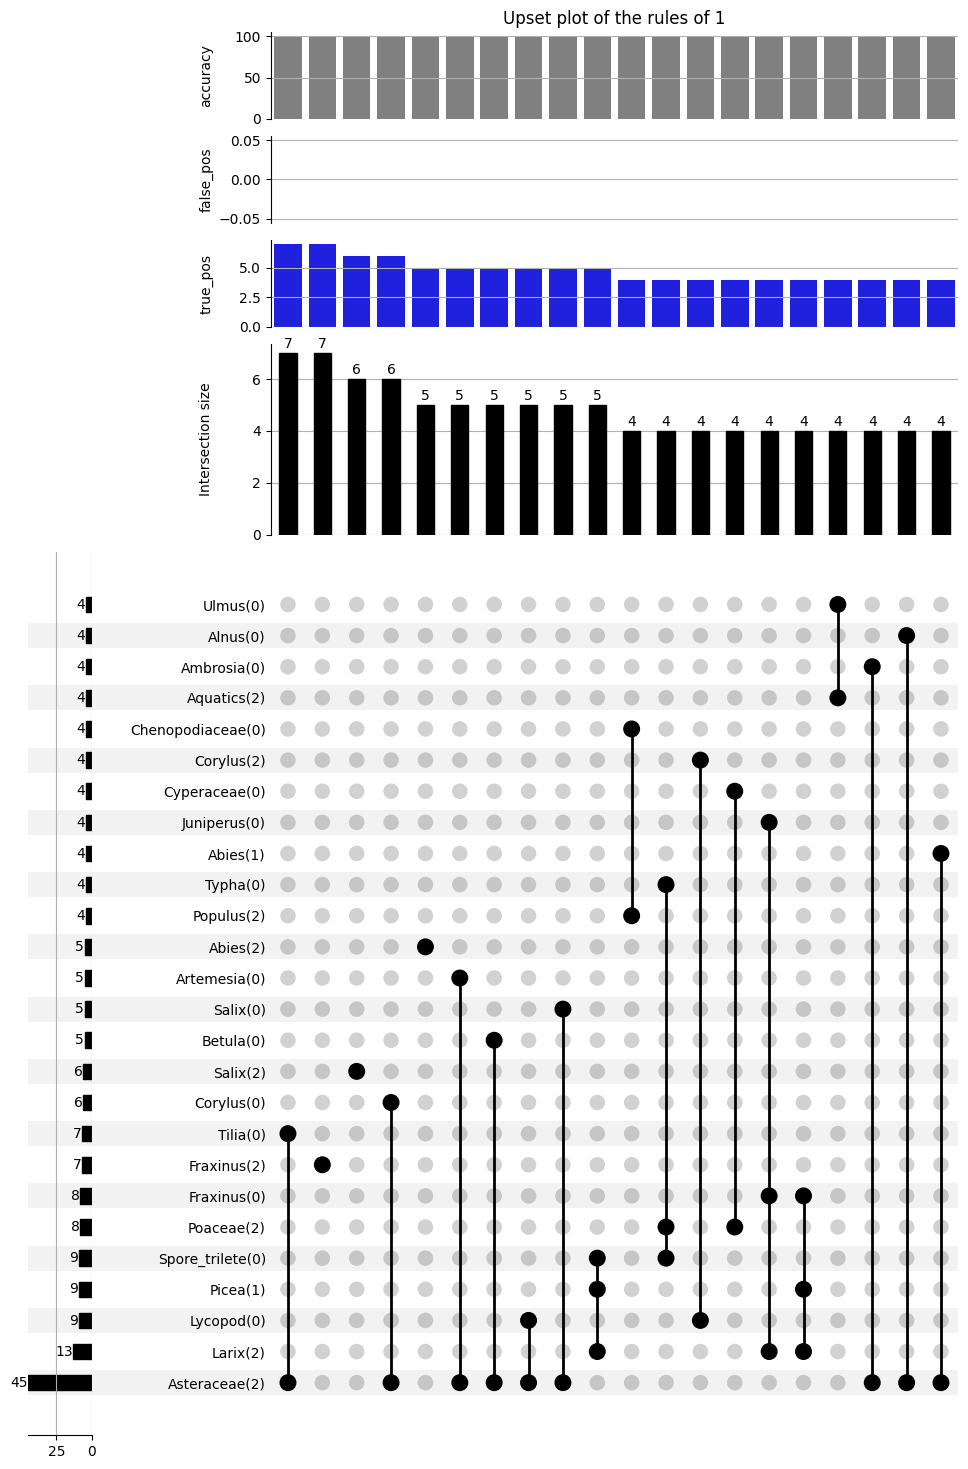

0


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_48783/3098058551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
301,O15,0,"Acer(0), Agoseris(0), Aquatics(0), Betula(0), ...",7,5,0,1.0,"[Acer(0), Agoseris(0), Aquatics(0), Betula(0),...",5.0
984,O15,0,"Abies(0), Pinus(1), Rosaceae(0), Typha(1)",4,5,0,1.0,"[Abies(0), Pinus(1), Rosaceae(0), Typha(1)]",5.0
1095,O15,0,"Aquatics(0), Poaceae(1), Typha(1)",3,5,0,1.0,"[Aquatics(0), Poaceae(1), Typha(1)]",5.0
313,O15,0,"Acer(0), Aquatics(0), Betula(0), Corylus(0), L...",6,5,0,1.0,"[Acer(0), Aquatics(0), Betula(0), Corylus(0), ...",5.0
600,O15,0,"Corylus(0), Typha(1), Ulmus(1)",3,4,0,1.0,"[Corylus(0), Typha(1), Ulmus(1)]",4.0
818,O15,0,"Abies(0), Agoseris(0), Aquatics(0), Betula(0)",4,4,0,1.0,"[Abies(0), Agoseris(0), Aquatics(0), Betula(0)]",4.0
806,O15,0,"Abies(0), Agoseris(0), Aquatics(0), Asteraceae...",5,4,0,1.0,"[Abies(0), Agoseris(0), Aquatics(0), Asteracea...",4.0
772,O15,0,"Abies(0), Betula(0), Pinus(1), Sarcobatus(0)",4,4,0,1.0,"[Abies(0), Betula(0), Pinus(1), Sarcobatus(0)]",4.0
788,O15,0,"Ambrosia(1), Aquatics(0), Poaceae(1)",3,4,0,1.0,"[Ambrosia(1), Aquatics(0), Poaceae(1)]",4.0
496,O15,0,"Corylus(0), Lycopod(0), Myrica(2)",3,4,0,1.0,"[Corylus(0), Lycopod(0), Myrica(2)]",4.0


['Abies(0)', 'Acer(0)', 'Agoseris(0)', 'Alnus(0)', 'Ambrosia(1)', 'Aquatics(0)', 'Artemesia(0)', 'Asteraceae(1)', 'Betula(0)', 'Carya(0)', 'Corylus(0)', 'Fraxinus(0)', 'Juniperus(0)', 'Lycopod(0)', 'Myrica(0)', 'Myrica(2)', 'Pinus(1)', 'Poaceae(1)', 'Rosaceae(0)', 'Sarcobatus(0)', 'Spore_trilete(0)', 'Typha(1)', 'Ulmus(1)']
23


true_pos  \
Abies(0) Acer(0) Agoseris(0) Alnus(0) Ambrosia(1) Aquatics(0) Artemesia(0) Asteraceae(1) Betula(0) Carya(0) Corylus(0) Fraxinus(0) Juniperus(0) Lycopod(0) Myrica(0) Myrica(2) Pinus(1) Poaceae(1) Rosaceae(0) Sarcobatus(0) Spore_trilete(0) Typha(1) Ulmus(1)             
False    False   False       False    False       False       False        False         False     False    True       False       False        False      False     False     False    False      False       False         False            True     True             4   
                                                                                                                                                True       False     True      False    False      False       False         False            False    False            4   
                                                                                                                                   True         False      False     True      False    False      False       False         False            False    False            4   
                                                                                                                       True        False        False      False     False     False    False      True        False         False            False    True             3   
                                                                                                                                                True       False     False     False    False      False       False         False            False    True             3   
                                                  True        False        False         False     False    False      False       False        False      False     False     False    True       False       False         False            True     False            5   
                                      True        True        False        False         False     False    False      False       False        False      False     False     False    True       False       False         False            False    False            4   
         True    False       False    False       False       False        False         False     False    True       False       False        False      False     True      False    False      False       False         False            False    False            4   
                                                  True        False        False         True      False    True       False       False        True       False     False     False    True       False       False         False            False    False            5   
                 True        False    False       True        False        False         True      False    False      False       False        True       False     False     False    True       False       False         True             False    False            5   
True     False   False       False    False       False       False        False         False     False    False      False       False        False      False     False     False    False      False       False         False            True     True             3   
                                                                                                                                                                               True     False      True        False         False            True     False            5   
                                                                                                            True       True        False        False      False     False     True     False      False       False         False            False    False            4   
                                                                                         True      False    False      False       False        False      False     False     True     False      False       True          F

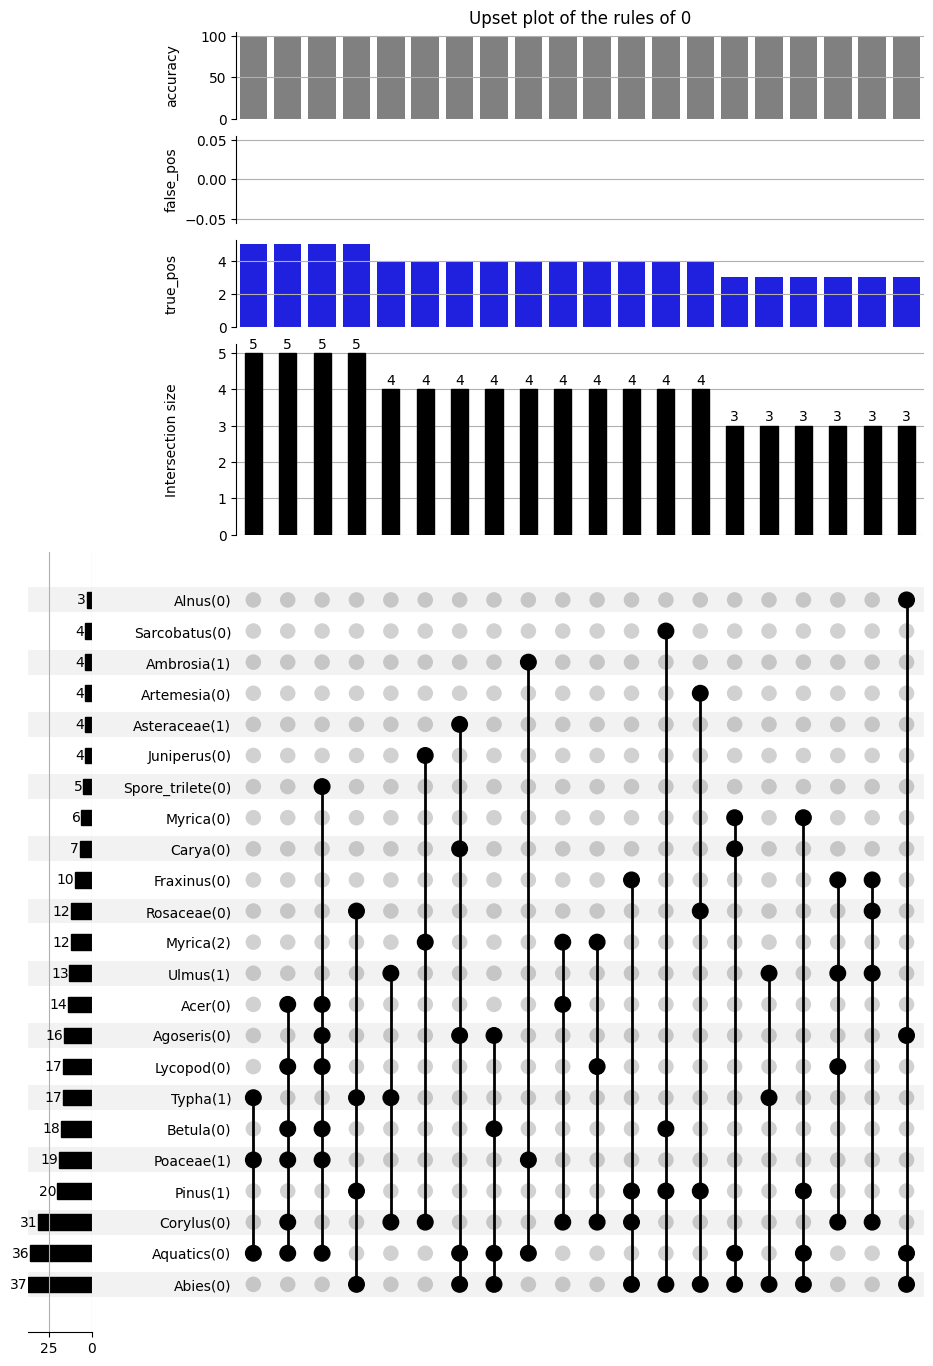

2


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_48783/3098058551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
82,O15,2,"Juniperus(0), Spore_monolete_(2)",2,1,0,1.0,"[Juniperus(0), Spore_monolete_(2)]",1.0
83,O15,2,"Spore_monolete_(2), Ulmus(1)",2,1,0,1.0,"[Spore_monolete_(2), Ulmus(1)]",1.0
1007,O15,2,"Abies(1), Aquatics(2), Typha(2)",3,1,0,1.0,"[Abies(1), Aquatics(2), Typha(2)]",1.0
860,O15,2,"Lycopod(1), Typha(2)",2,1,0,1.0,"[Lycopod(1), Typha(2)]",1.0
340,O15,2,"Aquatics(2), Fraxinus(1)",2,1,0,1.0,"[Aquatics(2), Fraxinus(1)]",1.0
339,O15,2,"Aquatics(2), Lycopod(1)",2,1,0,1.0,"[Aquatics(2), Lycopod(1)]",1.0
338,O15,2,"Aquatics(2), Sarcobatus(1)",2,1,0,1.0,"[Aquatics(2), Sarcobatus(1)]",1.0
203,O15,2,"Cyperaceae(2), Sarcobatus(1)",2,1,0,1.0,"[Cyperaceae(2), Sarcobatus(1)]",1.0
202,O15,2,"Cyperaceae(2), Juniperus(0)",2,1,0,1.0,"[Cyperaceae(2), Juniperus(0)]",1.0
201,O15,2,"Ambrosia(0), Cyperaceae(2)",2,1,0,1.0,"[Ambrosia(0), Cyperaceae(2)]",1.0


['Abies(1)', 'Ambrosia(0)', 'Aquatics(2)', 'Artemesia(0)', 'Cyperaceae(2)', 'Fraxinus(1)', 'Juniperus(0)', 'Larix(1)', 'Lycopod(1)', 'Picea(1)', 'Populus(1)', 'Quercus(0)', 'Salix(1)', 'Sarcobatus(1)', 'Spore_monolete_(2)', 'Typha(2)', 'Ulmus(1)']
17


true_pos  \
Abies(1) Ambrosia(0) Aquatics(2) Artemesia(0) Cyperaceae(2) Fraxinus(1) Juniperus(0) Larix(1) Lycopod(1) Picea(1) Populus(1) Quercus(0) Salix(1) Sarcobatus(1) Spore_monolete_(2) Typha(2) Ulmus(1)             
False    False       False       False        False         False       False        False    False      False    False      False      False    False         True               False    True             1   
                                                                                                                  True       False      False    False         True               False    False            1   
                                                                                              True       False    False      False      False    False         False              True     False            1   
                                                                        True         False    False      False    False      False      False    False         True               False    False            1   
                                              True          False       False        False    False      False    False      False      False    True          False              False    False            1   
                                                                                                                                        True     False         False              False    False            1   
                                                                                                                             True       False    False         False              False    False            1   
                                                                                                         True     False      False      False    False         False              False    False            1   
                                                                                              True       False    False      False      False    False         False              False    False            1   
                                                                                     True     False      False    False      False      False    False         False              False    False            1   
                                                                        True         False    False      False    False      False      False    False         False              False    False            1   
                                 True         True          False       False        False    False      False    False      False      False    False         False              False    False            1   
                     True        False        False         False       False        False    False      False    False      False      False    True          False              False    False            1   
                                                                                              True       False    False      False      False    False         False              False    False            1   
                                                            True        False        False    False      False    False      False      False    False         False              False    False            1   
                                              True          False       False        False    False      False    False      False      False    False         False              False    False            1   
         True        False       False        True          False       False        False    False      False    False      False      False    False         False              False    False            1   
True     False       False       False        True          False       False        False    False      False    False      False      False    False         False              False    False            1   
                 

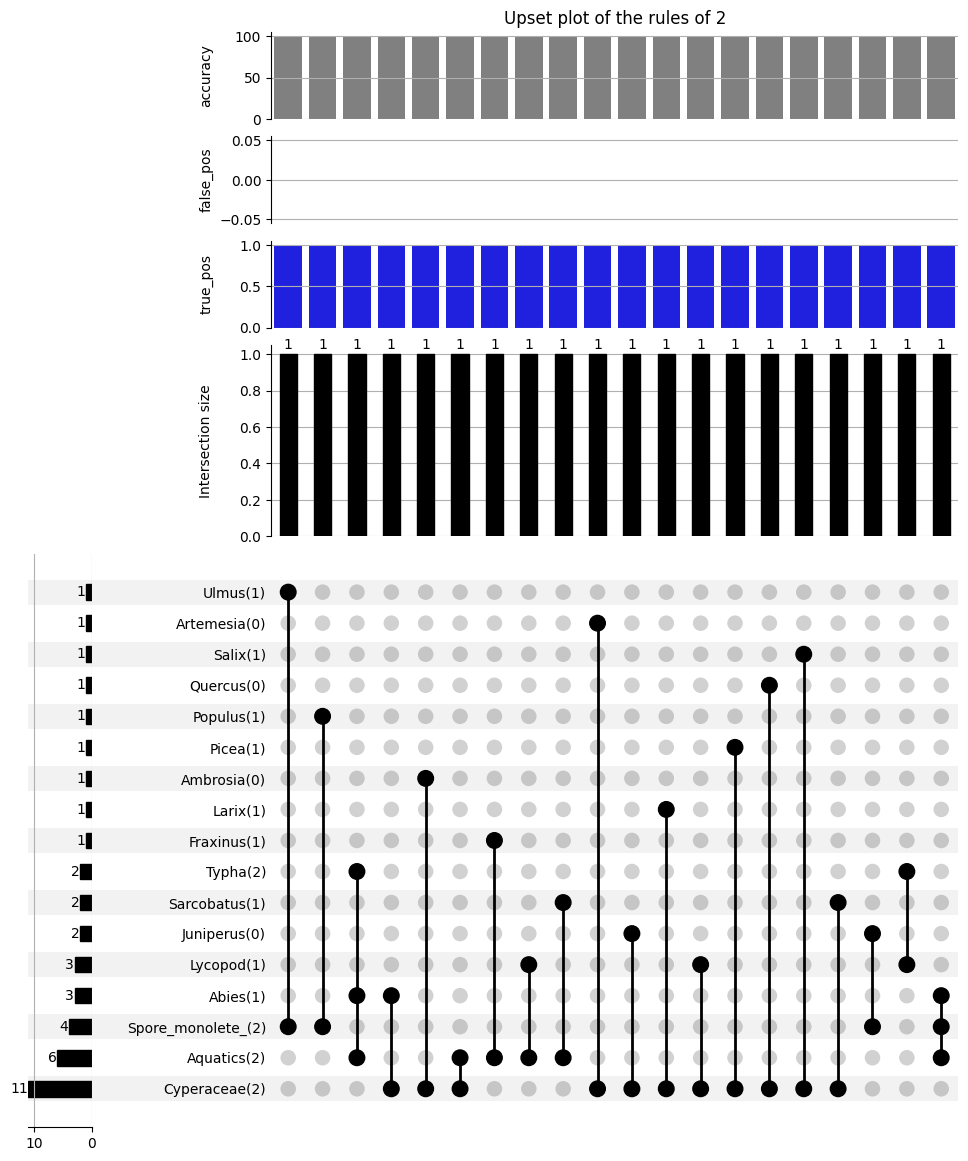

In [11]:
df_raw = df_output.copy()

df_raw["features"] = df_raw["body"].apply(lambda x: decode(x))

for head in df_raw["head_value"].unique():
    print(head)
    df = df_raw[(df_raw["head_value"] == head) & (df_raw["true_positives"] >= MIN_SUPPORT)]
    df["confidence"] = df["true_positives"] * df["accuracy"]
    df = df.sort_values("confidence", ascending=False).head(TOP_K_RULES)
    #df = df.sort_values("true_positives", ascending=False).head(TOP_K_RULES)

    display(df)

    features = set()
    for idx, row in df.iterrows():
        for i in row["features"]:
            features.add(i)

    features = list(features)
    features.sort()

    print(features)
    print(len(features))

    df_features = pd.DataFrame(columns=features)

    for idx, row in df.iterrows():
        data = {key:[False] for key in features}
        for condition in row["features"]:
            data[condition] = [True]
        df_features = pd.concat([df_features, pd.DataFrame(data)], axis=0).astype({key:bool for key in features})

    df_features["true_pos"] = df["true_positives"].values
    df_features["false_pos"] = df["false_positives"].values
    df_features["accuracy"] = df["accuracy"].values * 100
    df_features["confidence"] = df["confidence"].values
    df = df_features.reset_index(drop=True)

    # Clean useless column
    for col in features:
        if (not True in list(df[col].unique())):
            df = df.drop([col], axis=1)

    #display(df)

    conditions = [c for c in list(df.columns) if c not in ["true_pos","false_pos","accuracy","confidence"]]
    df = df.groupby(conditions).sum(numeric_only=True)
    display(df)

    upset = UpSet(df, show_counts=True, sort_by="cardinality", sum_over='confidence', subset_size="sum")
    #upset.add_catplot(kind="bar",value="false_pos")
    upset.add_catplot(kind="bar",value="true_pos", color="blue")
    upset.add_catplot(kind="bar",value="false_pos", color="red")
    upset.add_catplot(kind="bar",value="accuracy", color="gray")
    upset.plot()
    plt.title("Upset plot of the rules of "+str(head), loc="center")
    plt.savefig("tmp/upset_plot_lfit_"+str(head)+"_top_"+str(TOP_K_RULES)+"_lvl_"+str(LEVELS)+".pdf",bbox_inches='tight')
    plt.show()


# Vendiagram

In [12]:
def coverage(head_var, head_val, body,df):
    true_pos = 0
    false_pos = 0

    #print(body)

    conditions = body.split("), ")

    body = []
    for token in conditions:
        var = token.split("(")[0].strip()
        val = token.split("(")[1].split("(")[0].replace(")","").replace(".","").strip()
        if val.isdigit():
            val = int(val)
        body+= [(var,val)]

    #print((head_var, head_val), body)
        
    true_pos = []
    false_pos = []
    unknown_true_pos = []
    unknown_false_pos = []

    for idx, row in df.iterrows():
        matches = "FULL"
        for var,val in body:
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[head_var]) == str(head_val):
                true_pos += [idx]
            else:
                false_pos += [idx]
        elif matches == "PARTIAL":
            if str(row[head_var]) == str(head_val):
                unknown_true_pos += [idx]
            else:
                unknown_false_pos += [idx]

    
    #print(len(true_pos), len(false_pos), len(unknown_true_pos), len(unknown_false_pos))
    return true_pos, false_pos, unknown_true_pos, unknown_false_pos
    
df = pd.read_csv(INPUT_DATA_DISCRETE)
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')
df = df.fillna("?")
display(df)

tp, fp, utp, ufp = coverage("M15", "0", "Abies(1), Pinus(1)", df)
print(len(tp), len(fp), len(utp), len(ufp))

,O15,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore_monolete_,Spore_trilete,Aquatics
0,1,1,1,2,2,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,1,1,1,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,2,2,0
2,1,1,2,2,2,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,1,2,2,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,1,2,0,2,2,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
5,1,2,0,1,1,1,0,0,1,0,...,1,1,1,1,0,1,0,0,0,0
6,0,0,1,2,2,1,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0
7,1,1,0,2,1,1,0,0,0,0,...,2,0,0,0,0,1,1,1,0,2
8,2,1,0,1,1,1,0,0,1,0,...,0,0,1,0,1,0,2,2,0,2
9,1,2,0,2,2,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1


KeyError: 'M15'

In [ ]:
from matplotlib_venn import venn3

# find subset of rules of max size that cover all sample
df_data = pd.read_csv(INPUT_DATA_DISCRETE)
cols = [c for c in df_data.columns if c not in list(df_data.select_dtypes(exclude=["number"]).columns)]
df_data[cols] = df_data[cols].astype('Int64')
df_data[cols] = df_data[cols].astype('string')
df_data = df_data.fillna("?")
#df_data = df_data.dropna() # DBG remove if nan lfit mode
#display(df_data)
df_rules = df_output.copy()

for head_value in list(df_rules["head_value"].unique()):
    # Extract top rules
    df_rules = df_output.copy()
    df_rules = df_rules[(df_rules["head_value"] == head_value) & (df_rules["true_positives"] >= MIN_SUPPORT)]

    # DBG
    #df_rules = df_rules.sort_values("train_true_positives", ascending=False).reset_index(drop=True)
    #df_rules = df_rules.truncate(before=19417).reset_index(drop=True)
    df_rules = df_rules.sort_values("true_positives", ascending=False).reset_index(drop=True).head(VEN_TOP_K_RULES).reset_index(drop=True)
    #display(df_rules)

    # Compute covering
    rule_covering = {}
    for idx, row in df_rules.iterrows():
        tp, fp, utp, ufp = coverage(row["head_variable"], row["head_value"], row["body"], df_data)
        rule_covering[idx] = {"tp":set(tp), "fp":set(fp), "utp":set(utp), "ufp":set(ufp)}
        print("\r",idx+1,"/",len(df_rules),end="")
    print()

    # Greedy search for minimal set covering
    remaining = set(df_data[df_data[TARGETS[0]] == head_value].index.values.tolist())
    total_to_cover = len(remaining)
    selection = []
    while (len(remaining) > 0) and (len(rule_covering) > 0) and (len(selection) < 3):
        print("Remaining:",len(remaining))

        covering = []
        for rule_id in rule_covering:
            new_tp = len(remaining.intersection(rule_covering[rule_id]["tp"])) + len(remaining.intersection(rule_covering[rule_id]["utp"]))
            if (new_tp > 0):
                covering += [(rule_id, new_tp, len(rule_covering[rule_id]["fp"]) + len(rule_covering[rule_id]["ufp"]))]
        covering.sort(key = lambda x: (x[1],-x[2]),reverse=True) # Maximize TP, minimize FP
        print(covering)

        if covering[0][1] == 0:
            print("No rule cover the remaining observations")
            break

        top_rule_id = covering[0][0]
        selection += [top_rule_id]
        remaining = remaining - rule_covering[top_rule_id]["tp"] - rule_covering[top_rule_id]["utp"]
        #del rule_covering[top_rule_id]


    # True positives covering
    set1 = set(rule_covering[selection[0]]["tp"]).union(rule_covering[selection[0]]["utp"])
    set2 = set(rule_covering[selection[1]]["tp"]).union(rule_covering[selection[1]]["utp"])
    set3 = set(rule_covering[selection[2]]["tp"]).union(rule_covering[selection[2]]["utp"])

    venn3([set1, set2, set3], ("Rule "+str(selection[0]), "Rule "+str(selection[1]), "Rule "+str(selection[2])))

    nb_covered = total_to_cover-len(remaining)
    pct_covered = int(nb_covered / total_to_cover * 100)
    r0 = decode(df_rules["body"].iloc[[selection[0]]].values[0])
    r1 = decode(df_rules["body"].iloc[[selection[1]]].values[0])
    r2 = decode(df_rules["body"].iloc[[selection[2]]].values[0])
    plt.title(str(head_value)+" true positives covering "+str(nb_covered)+"/"+str(total_to_cover)+" (~"+str(pct_covered)+"%)")
    print("Rule "+str(selection[0])+": "+str(r0))
    print("Rule "+str(selection[1])+": "+str(r1))
    print("Rule "+str(selection[2])+": "+str(r2))
    #plt.text(1, 0, "Rule "+str(selection[0])+": "+str(r0), fontsize = 12) 
    #plt.text(1, -0.1, "Rule "+str(selection[1])+": "+str(r1), fontsize = 12)
    #plt.text(1, -0.2, "Rule "+str(selection[2])+": "+str(r2), fontsize = 12)
    plt.savefig("tmp/ven_diag_"+str(head_value)+"_TP.pdf",bbox_inches='tight')
    plt.show()

    #if dataset_name == "PREVHAP":
    # False positives covering
    set1 = set(rule_covering[selection[0]]["ufp"]).union(rule_covering[selection[0]]["fp"])
    set2 = set(rule_covering[selection[1]]["ufp"]).union(rule_covering[selection[1]]["fp"])
    set3 = set(rule_covering[selection[2]]["ufp"]).union(rule_covering[selection[2]]["fp"])

    venn3([set1, set2, set3], ("Rule "+str(selection[0]), "Rule "+str(selection[1]), "Rule "+str(selection[2])))

    total_to_cover = len(set(df_data[df_data[TARGETS[0]] != head_value].index.values.tolist()))
    nb_covered = set1
    nb_covered.update(set2)
    nb_covered.update(set3)
    nb_covered = len(nb_covered)
    pct_covered = int(nb_covered / total_to_cover * 100)
    r0 = decode(df_rules["body"].iloc[[selection[0]]].values[0])
    r1 = decode(df_rules["body"].iloc[[selection[1]]].values[0])
    r2 = decode(df_rules["body"].iloc[[selection[2]]].values[0])
    print("Rule "+str(selection[0])+": "+str(r0))
    print("Rule "+str(selection[1])+": "+str(r1))
    print("Rule "+str(selection[2])+": "+str(r2))
    plt.title(str(head_value)+" false positives covering "+str(nb_covered)+"/"+str(total_to_cover)+" (~"+str(pct_covered)+"%)")
    #plt.text(1, 0, "Rule "+str(selection[0])+": "+str(r0), fontsize = 12) 
    #plt.text(1, -0.1, "Rule "+str(selection[1])+": "+str(r1), fontsize = 12)
    #plt.text(1, -0.2, "Rule "+str(selection[2])+": "+str(r2), fontsize = 12)
    plt.savefig("tmp/ven_diag_"+str(head_value)+"_FP.pdf",bbox_inches='tight')
    plt.show()



# TODO